In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric as T
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv, GATConv, global_mean_pool, global_add_pool, global_max_pool
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

import networkx as nx

from sklearn.metrics import roc_curve, roc_auc_score
from statistics import mean
import seaborn as sns

In [97]:
# Read from csv
sig_df = pd.read_csv('Dijet_bb_pt20_50_dw.csv')
bkg_df = pd.read_csv('Dijet_qq_pt20_50_dw.csv')

In [98]:
full_df = pd.concat([sig_df, bkg_df])

In [99]:
full_df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,nITClusters,nTTClusters,nOTClusters,nSPDHits,nMuonCoordsS0,nMuonCoordsS1,nMuonCoordsS2,nMuonCoordsS3,nMuonCoordsS4,nMuonTracks
0,0.8738,-0.1754,14.7203,0.0093,0.0093,0.0573,49.857929,107,0.766100,-0.200700,...,671,875,5547,328,349,154,50,6,6,10
1,0.7844,-0.1852,-61.7426,0.0074,0.0073,0.0379,68.600578,167,0.783929,-0.185155,...,926,894,5557,403,409,109,14,4,7,5
2,0.8658,-0.1414,-9.7498,0.0101,0.0101,0.0570,21.601925,57,0.862175,-0.136493,...,370,545,3854,158,179,56,33,7,6,1
3,0.8803,-0.1820,28.3628,0.0094,0.0093,0.0503,40.823803,91,0.881767,-0.183634,...,105,556,2695,118,129,114,33,4,9,3
4,0.8163,-0.0868,8.4282,0.0286,0.0275,0.3193,7.705523,13,0.799059,-0.161079,...,1169,1391,8587,586,668,243,19,14,14,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.9319,-0.1551,-26.4473,0.0114,0.0115,0.0678,23.666225,51,0.931997,-0.157303,...,701,1017,5846,481,497,226,18,3,18,5
199996,0.9319,-0.1551,-26.4473,0.0114,0.0115,0.0678,23.666225,51,0.931997,-0.157303,...,701,1017,5846,481,497,226,18,3,18,5
199997,0.9319,-0.1551,-26.4473,0.0114,0.0115,0.0678,23.666225,51,0.931997,-0.157303,...,701,1017,5846,481,497,226,18,3,18,5
199998,0.9319,-0.1551,-26.4473,0.0114,0.0115,0.0678,23.666225,51,0.931287,-0.153498,...,701,1017,5846,481,497,226,18,3,18,5


In [100]:
# Distinguish signal and background
sig_df['IsB'] = 1
bkg_df['IsB'] = 0

# Separate Jet 0 and Jet 1 data
sig_df = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsB")]]
bkg_df = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsB")]]

sig_df = sig_df[(sig_df['Jet0_MC_Match'] == 1) &
                (sig_df['Jet0_MC_Jet_EfB'] > 0.6) &
                (sig_df['Jet0_PT'] > 20000) &
                (sig_df['Jet0_Eta'].between(2.2, 4.4))]
bkg_df = bkg_df[(bkg_df['Jet0_MC_Match'] == 1) &
                (bkg_df['Jet0_MC_Jet_EfB'] < 0.6) &
                (bkg_df['Jet0_MC_Jet_EfD'] < 0.6) &
                (bkg_df['Jet0_PT'] > 20000) &
                (bkg_df['Jet0_Eta'].between(2.2, 4.4))]

# Combine signal and background
combined_df = pd.concat([sig_df, bkg_df])

In [101]:
combined_df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,Jet0_Hlt1Phys_Dec,Jet0_Hlt1Phys_TIS,Jet0_Hlt1Phys_TOS,Jet0_Hlt2Global_Dec,Jet0_Hlt2Global_TIS,Jet0_Hlt2Global_TOS,Jet0_Hlt2Phys_Dec,Jet0_Hlt2Phys_TIS,Jet0_Hlt2Phys_TOS,IsB
0,0.8738,-0.1754,14.7203,0.0093,0.0093,0.0573,49.857929,107,0.766100,-0.200700,...,True,True,True,True,True,True,True,True,True,1
2,0.8658,-0.1414,-9.7498,0.0101,0.0101,0.0570,21.601925,57,0.862175,-0.136493,...,True,True,True,True,True,True,True,True,False,1
3,0.8803,-0.1820,28.3628,0.0094,0.0093,0.0503,40.823803,91,0.881767,-0.183634,...,True,True,True,True,True,True,True,True,True,1
5,0.8163,-0.0868,8.4282,0.0286,0.0275,0.3193,7.705523,13,0.811200,-0.098801,...,False,False,False,True,False,False,True,False,False,1
7,0.8163,-0.0868,8.4282,0.0286,0.0275,0.3193,7.705523,13,0.811200,-0.098801,...,False,False,False,True,False,False,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199992,0.8769,-0.2248,42.3909,0.0252,0.0213,0.2080,10.417310,25,0.880671,-0.233220,...,True,True,True,True,True,True,True,True,True,0
199994,0.9319,-0.1551,-26.4473,0.0114,0.0115,0.0678,23.666225,51,0.931997,-0.157303,...,False,False,False,True,False,False,True,False,False,0
199995,0.9319,-0.1551,-26.4473,0.0114,0.0115,0.0678,23.666225,51,0.931997,-0.157303,...,False,False,False,True,False,False,True,False,False,0
199996,0.9319,-0.1551,-26.4473,0.0114,0.0115,0.0678,23.666225,51,0.931997,-0.157303,...,False,False,False,True,False,False,True,False,False,0


In [102]:
def prepare_features(df, jet_cols, daughter_cols):
    # Duplicate data to lists matching the number of daughters/nodes per jet/row
    for col in jet_cols:
        df[col] = df.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)

    # Convert string values into list of floats
    for col in daughter_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

In [103]:
daughter_cols = [col for col in sig_df.columns if "_Daughters" in col]
svtag_cols = [col for col in sig_df.columns if "SVtag" in col]
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
feature_cols = daughter_cols + jet_cols

In [106]:
len(svtag_cols)

17

In [107]:
list(svtag_cols)

['Jet0_SVtag_fdrMin',
 'Jet0_SVtag_ptSvrJet',
 'Jet0_SVtag_nTrk',
 'Jet0_SVtag_nTrkJet',
 'Jet0_SVtag_drSvrJet',
 'Jet0_SVtag_absQSum',
 'Jet0_SVtag_m',
 'Jet0_SVtag_mCor',
 'Jet0_SVtag_fdChi2',
 'Jet0_SVtag_ipChi2Sum',
 'Jet0_SVtag_bdt0',
 'Jet0_SVtag_bdt1',
 'Jet0_SVtag_pass',
 'Jet0_SVtag_tau',
 'Jet0_SVtag_z',
 'Jet0_SVtag_pt',
 'Jet0_SVtag_backwards']

In [108]:
# Duplicate single features for each node
df = prepare_features(combined_df, jet_cols, daughter_cols)

In [109]:
df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,Jet0_Hlt1Phys_Dec,Jet0_Hlt1Phys_TIS,Jet0_Hlt1Phys_TOS,Jet0_Hlt2Global_Dec,Jet0_Hlt2Global_TIS,Jet0_Hlt2Global_TOS,Jet0_Hlt2Phys_Dec,Jet0_Hlt2Phys_TIS,Jet0_Hlt2Phys_TOS,IsB
0,0.8738,-0.1754,14.7203,0.0093,0.0093,0.0573,49.857929,107,0.766100,-0.200700,...,True,True,True,True,True,True,True,True,True,1
2,0.8658,-0.1414,-9.7498,0.0101,0.0101,0.0570,21.601925,57,0.862175,-0.136493,...,True,True,True,True,True,True,True,True,False,1
3,0.8803,-0.1820,28.3628,0.0094,0.0093,0.0503,40.823803,91,0.881767,-0.183634,...,True,True,True,True,True,True,True,True,True,1
5,0.8163,-0.0868,8.4282,0.0286,0.0275,0.3193,7.705523,13,0.811200,-0.098801,...,False,False,False,True,False,False,True,False,False,1
7,0.8163,-0.0868,8.4282,0.0286,0.0275,0.3193,7.705523,13,0.811200,-0.098801,...,False,False,False,True,False,False,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199992,0.8769,-0.2248,42.3909,0.0252,0.0213,0.2080,10.417310,25,0.880671,-0.233220,...,True,True,True,True,True,True,True,True,True,0
199994,0.9319,-0.1551,-26.4473,0.0114,0.0115,0.0678,23.666225,51,0.931997,-0.157303,...,False,False,False,True,False,False,True,False,False,0
199995,0.9319,-0.1551,-26.4473,0.0114,0.0115,0.0678,23.666225,51,0.931997,-0.157303,...,False,False,False,True,False,False,True,False,False,0
199996,0.9319,-0.1551,-26.4473,0.0114,0.0115,0.0678,23.666225,51,0.931997,-0.157303,...,False,False,False,True,False,False,True,False,False,0


In [110]:
# Split data 80:20 w equal parts sig/bkg then shuffle (24000 sig, 6000 bkg)
sig_df = df[df['IsB'] == 1]
bkg_df = df[df['IsB'] == 0]

train_df = pd.concat([sig_df.head(12000), bkg_df.head(12000)]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([sig_df.tail(3000), bkg_df.tail(3000)]).sample(frac=1, random_state=42).reset_index(drop=True)

In [111]:
sum(train_df.IsB)

12000

In [112]:
sum(test_df.IsB)

3000

In [113]:
training_data = train_df[feature_cols]
testing_data = test_df[feature_cols]

In [114]:
training_data

,Jet0_Daughters_E,Jet0_Daughters_pT,Jet0_Daughters_ID,Jet0_Daughters_pX,Jet0_Daughters_pY,Jet0_Daughters_pZ,Jet0_Daughters_Eta,Jet0_Daughters_Phi,Jet0_Daughters_Q,Jet0_Daughters_IP,...,Jet0_SVtag_mCor,Jet0_SVtag_fdChi2,Jet0_SVtag_ipChi2Sum,Jet0_SVtag_bdt0,Jet0_SVtag_bdt1,Jet0_SVtag_pass,Jet0_SVtag_tau,Jet0_SVtag_z,Jet0_SVtag_pt,Jet0_SVtag_backwards
0,"[13194.3984375, 5563.22021484375, 5035.3046875...","[343.78204345703125, 166.88829040527344, 220.3...","[211.0, 22.0, 211.0, 321.0, -211.0, -211.0, -2...","[-259.6786193847656, -116.18250274658203, -125...","[-225.28451538085938, -119.80538177490234, -18...","[13189.1806640625, 5560.71630859375, 5028.5434...","[4.340461254119873, 4.199529647827148, 3.82117...","[-2.426996946334839, -2.340843677520752, -2.17...","[1.0, 0.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 0....","[-0.0035699785221368074, -100.0, -0.1688256263...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[13017.5146484375, 4414.18994140625, 5769.8090...","[699.377197265625, 257.1174621582031, 399.1422...","[321.0, 22.0, 22.0, 22.0, -211.0, 22.0, -22.0,...","[571.3621826171875, 244.7260284423828, 397.586...","[403.3283386230469, 78.85781860351562, -35.205...","[12989.3359375, 4406.6953125, 5755.98681640625...","[3.6155648231506348, 3.5353446006774902, 3.363...","[0.6146791577339172, 0.3117235600948334, -0.08...","[1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0,...","[-0.05803072825074196, -100.0, -100.0, -100.0,...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[3446.7060546875, 22096.01953125, 5585.25, 410...","[162.46437072753906, 1647.8843994140625, 628.9...","[22.0, -2212.0, 22.0, 22.0, 22.0, 22.0, 211.0,...","[50.24778747558594, 780.0322875976562, 46.4706...","[154.49864196777344, 1451.5758056640625, 627.1...","[3442.875, 22014.5, 5549.72802734375, 4092.927...","[3.7473068237304688, 3.2867541313171387, 2.873...","[1.2563552856445312, 1.0777020454406738, 1.496...","[0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0,...","[-100.0, -0.07602924853563309, -100.0, -100.0,...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[38320.78125, 4578.4677734375, 11788.580078125...","[3829.4521484375, 403.346435546875, 1281.64343...","[22.0, -211.0, 22.0, 22.0, -211.0, 22.0, 22.0,...","[-3535.61669921875, -376.6382751464844, -424.8...","[-1471.0943603515625, -144.33277893066406, -12...","[38128.95703125, 4558.5302734375, 11718.703125...","[2.9939117431640625, 3.120058536529541, 2.9091...","[-2.747302770614624, -2.7756407260894775, -1.9...","[0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0...","[-100.0, 0.06230470910668373, -100.0, -1

In [115]:
testing_data[svtag_cols]

,Jet0_SVtag_fdrMin,Jet0_SVtag_ptSvrJet,Jet0_SVtag_nTrk,Jet0_SVtag_nTrkJet,Jet0_SVtag_drSvrJet,Jet0_SVtag_absQSum,Jet0_SVtag_m,Jet0_SVtag_mCor,Jet0_SVtag_fdChi2,Jet0_SVtag_ipChi2Sum,Jet0_SVtag_bdt0,Jet0_SVtag_bdt1,Jet0_SVtag_pass,Jet0_SVtag_tau,Jet0_SVtag_z,Jet0_SVtag_pt,Jet0_SVtag_backwards
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[8.021249771118164, 8.021249771118164, 8.02124...","[0.6751056909561157, 0.6751056909561157, 0.675...","[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ...","[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ...","[0.0412803702056407, 0.0412803702056407, 0.041...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3800.540771484375, 3800.540771484375, 3800.54...","[4154.6005859375, 4154.6005859375, 4154.600585...","[222664.390625, 222664.390625, 222664.390625, ...","[14901.5419921875, 14901.5419921875, 14901.541...","[0.8347104787826538, 0.8347104787826538, 0.834...","[0.8324108123779297, 0.8324108123779297, 0.832...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.4501863718032837, 0.4501863718032837, 0.450...","[116.50852966308594, 116.50852966308594, 116.5...","[23790.828125, 23790.828125, 23790.828125, 237...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0,

In [116]:
# Create node feature array: [jet][daughter][feature]
def node_features(df):
    features_list = []
    
    for _, row in df.iterrows():
        num_nodes = row['Jet0_nDaughters']
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    return np.array(features_list, dtype=object)

# Create graphs for each jet - orig
def create_data_objects(df, features_array):
    data_objects = []
    for idx, features in enumerate(features_array):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        # Fully connected edges
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        y = torch.tensor([df['IsB'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Extract node features
train_features = node_features(train_df)
test_features = node_features(test_df)

# Create graphs for each jet
train_data = create_data_objects(train_df, train_features)
test_data = create_data_objects(test_df, test_features)

# Load Data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [117]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 128
        self.conv1 = SAGEConv(len(feature_cols), hidden_channels)
        self.ln1 = LayerNorm(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.ln2 = LayerNorm(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.ln3 = LayerNorm(hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        self.ln4 = LayerNorm(hidden_channels)
        self.lin = Linear(hidden_channels, 1)
        self.dropout = Dropout(0.2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.ln3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index)
        x = self.ln4(x)
        x = F.relu(x)

        x = global_add_pool(x, batch)  # [batch_size, hidden_channels]
        
        x = self.lin(x)
        return x.squeeze(1)

model = GNN()

In [118]:
# Define optimizer and criterion
optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


# Training loop
def train(loader):
    model.train()
    total_loss = 0

    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.float())
        clip_grad_norm_(model.parameters(), max_norm=0.5)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        
    return total_loss / len(train_loader.dataset)

# Testing function
def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = (out > 0).float() # converts logits to binary prediction
            correct = (pred.squeeze() == data.y.float()).sum().item()
            total_correct += correct
            total_samples += len(data.y)
    
    return total_correct / total_samples

# Check gradients
def check_gradients():
    model.train()
    data = next(iter(train_loader))
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.batch)
    loss = criterion(out.squeeze(-1), data.y.float())
    loss.backward()

    print(' ')
    print('Grad norms:')
    for name, param in model.named_parameters():
        if param.requires_grad:
            if param.grad is not None:
                grad_norm = param.grad.norm().item()
                print(f"    {name}: {grad_norm:.6f}")

# Training parameters
num_epochs = 100

# Lists to store loss and accuracy values
train_loss_values = []
test_loss_values = []
train_acc_values = []
test_acc_values = []

# Training loop
for epoch in range(num_epochs):
    trainloss = train(train_loader)
    testloss = train(test_loader)
    train_loss_values.append(trainloss)
    test_loss_values.append(testloss)
    train_acc = test(train_loader)
    train_acc_values.append(train_acc)
    test_acc = test(test_loader)
    test_acc_values.append(test_acc)
    scheduler.step(test_acc)

    print(f'Epoch: {epoch+1:03d}, Train Loss: {trainloss:.4f}, Test Loss: {testloss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Check gradients after training
check_gradients()

Epoch: 001, Train Loss: 0.7612, Test Loss: 0.1089, Train Acc: 0.7968, Test Acc: 0.8042
Epoch: 002, Train Loss: 0.4445, Test Loss: 0.1065, Train Acc: 0.7961, Test Acc: 0.8112
Epoch: 003, Train Loss: 0.4369, Test Loss: 0.1060, Train Acc: 0.7925, Test Acc: 0.8068
Epoch: 004, Train Loss: 0.4353, Test Loss: 0.1049, Train Acc: 0.7941, Test Acc: 0.8075
Epoch: 005, Train Loss: 0.4325, Test Loss: 0.1047, Train Acc: 0.7937, Test Acc: 0.8077
Epoch: 006, Train Loss: 0.4328, Test Loss: 0.1037, Train Acc: 0.7941, Test Acc: 0.8082
Epoch: 007, Train Loss: 0.4320, Test Loss: 0.1042, Train Acc: 0.7937, Test Acc: 0.8080
Epoch: 008, Train Loss: 0.4289, Test Loss: 0.1026, Train Acc: 0.7943, Test Acc: 0.8082
Epoch: 009, Train Loss: 0.4286, Test Loss: 0.1025, Train Acc: 0.7943, Test Acc: 0.8082
Epoch: 010, Train Loss: 0.4280, Test Loss: 0.1025, Train Acc: 0.7943, Test Acc: 0.8082
Epoch: 011, Train Loss: 0.4291, Test Loss: 0.1025, Train Acc: 0.7943, Test Acc: 0.8082
Epoch: 012, Train Loss: 0.4276, Test Loss: 

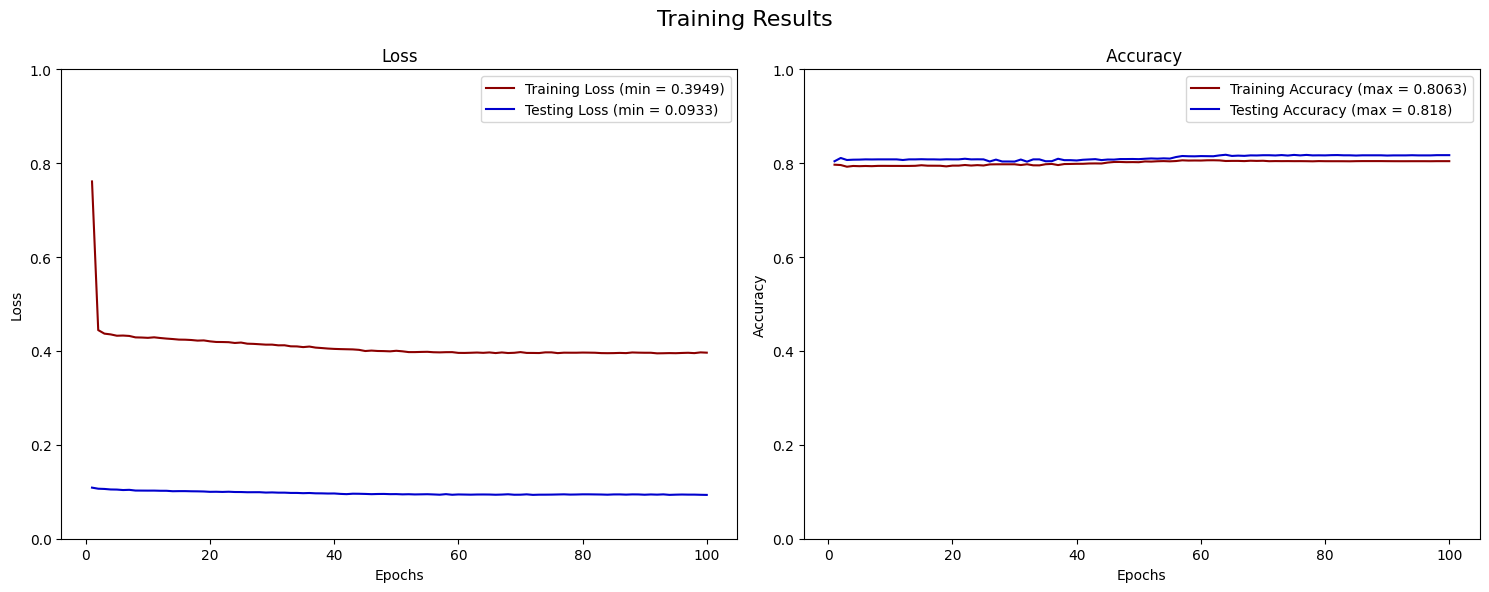

In [119]:
# Plot Loss and Accuracy
def plot_training_results():
    epochs = range(1, len(train_loss_values) + 1)

    mean_train_loss = mean(train_loss_values)
    mean_test_loss = mean(test_loss_values)
    mean_train_acc = mean(train_acc_values)
    mean_test_acc = mean(test_acc_values)

    min_train_loss = min(train_loss_values)
    min_test_loss = min(test_loss_values)
    max_train_acc = max(train_acc_values)
    max_test_acc = max(test_acc_values)

    final_train_loss = train_loss_values[-1]
    final_test_loss = test_loss_values[-1]
    final_train_acc = train_acc_values[-1]
    final_test_acc = test_acc_values[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Training Results', fontsize=16)

    # Plot Loss
    ax1.plot(epochs, train_loss_values, color='darkred', label=(f"Training Loss (min = {min_train_loss:.4f})"))
    ax1.plot(epochs, test_loss_values, color='mediumblue', label=(f"Testing Loss (min = {min_test_loss:.4f})"))
    ax1.set_ylim(0, 1)
    #ax1.set_xlim(0, 50)
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot  Accuracy
    ax2.plot(epochs, train_acc_values, color='darkred', label=(f"Training Accuracy (max = {max_train_acc:.4f})"))
    ax2.plot(epochs, test_acc_values, color='mediumblue', label=(f"Testing Accuracy (max = {max_test_acc:.4})"))
    ax2.set_ylim(0, 1)
    #ax2.set_xlim(0, 50)
    ax2.set_title(' Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.tight_layout()
    plt.show()

# After your training loop, call the function:
plot_training_results()

Compute ROC Curve and AUC

In [120]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

In [121]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

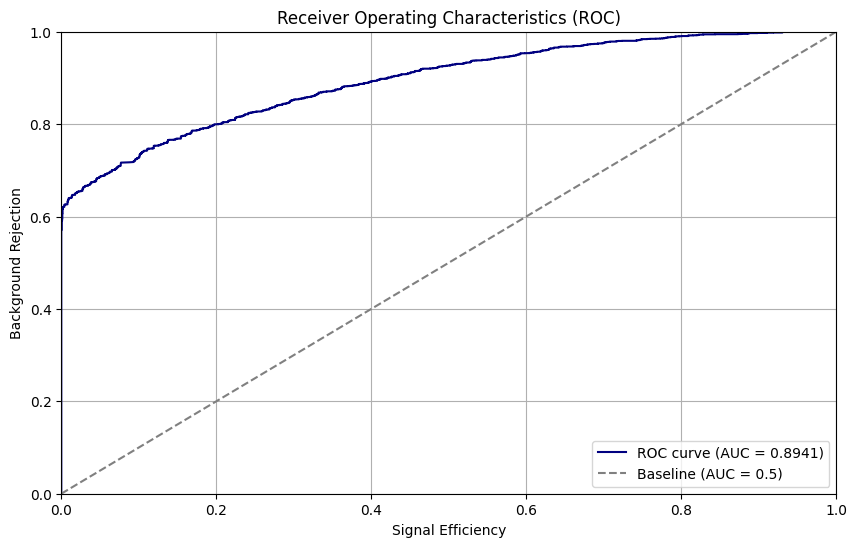

In [134]:
# Plot ROC Curve and show AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Background Rejection')
plt.xlabel('Signal Efficiency')
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

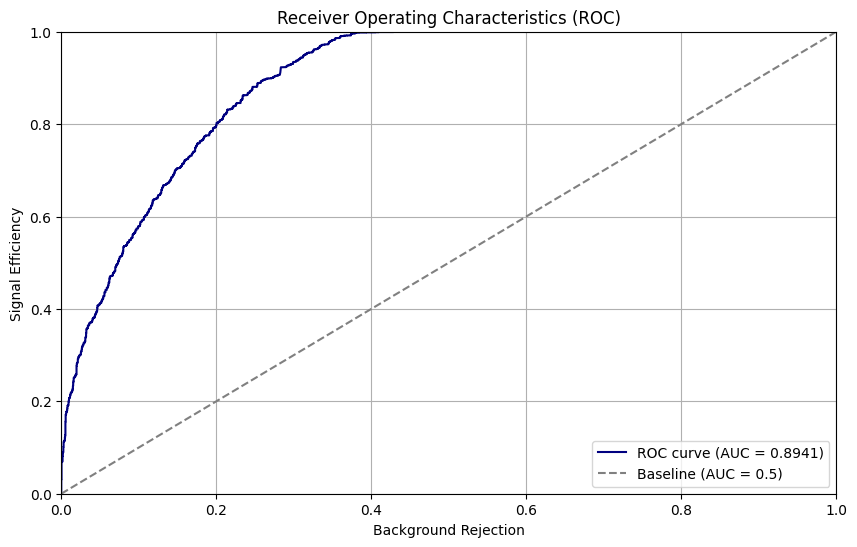

In [139]:
# Plot ROC Curve and show AUC
plt.figure(figsize=(10, 6))
plt.plot(1-tpr, 1-fpr, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Signal Efficiency')
plt.xlabel('Background Rejection')
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Analyze strength of features - feature abblation

                                Feature  Importance
0                      Jet0_Daughters_E    0.405651
1                     Jet0_Daughters_pT    0.615525
2                     Jet0_Daughters_ID    0.066428
3                     Jet0_Daughters_pX    0.120866
4                     Jet0_Daughters_pY    0.189713
5                     Jet0_Daughters_pZ    0.510019
6                    Jet0_Daughters_Eta    0.001467
7                    Jet0_Daughters_Phi    0.000757
8                      Jet0_Daughters_Q    0.000122
9                     Jet0_Daughters_IP    0.004408
10                Jet0_Daughters_IPCHI2    0.653612
11                 Jet0_Daughters_IPraw    0.007937
12                   Jet0_Daughters_NNe    0.037831
13                   Jet0_Daughters_NNk    0.038185
14                   Jet0_Daughters_NNp    0.043964
15                  Jet0_Daughters_NNpi    0.037172
16                  Jet0_Daughters_NNmu    0.180324
17                  Jet0_Daughters_Chi2    0.038063
18          

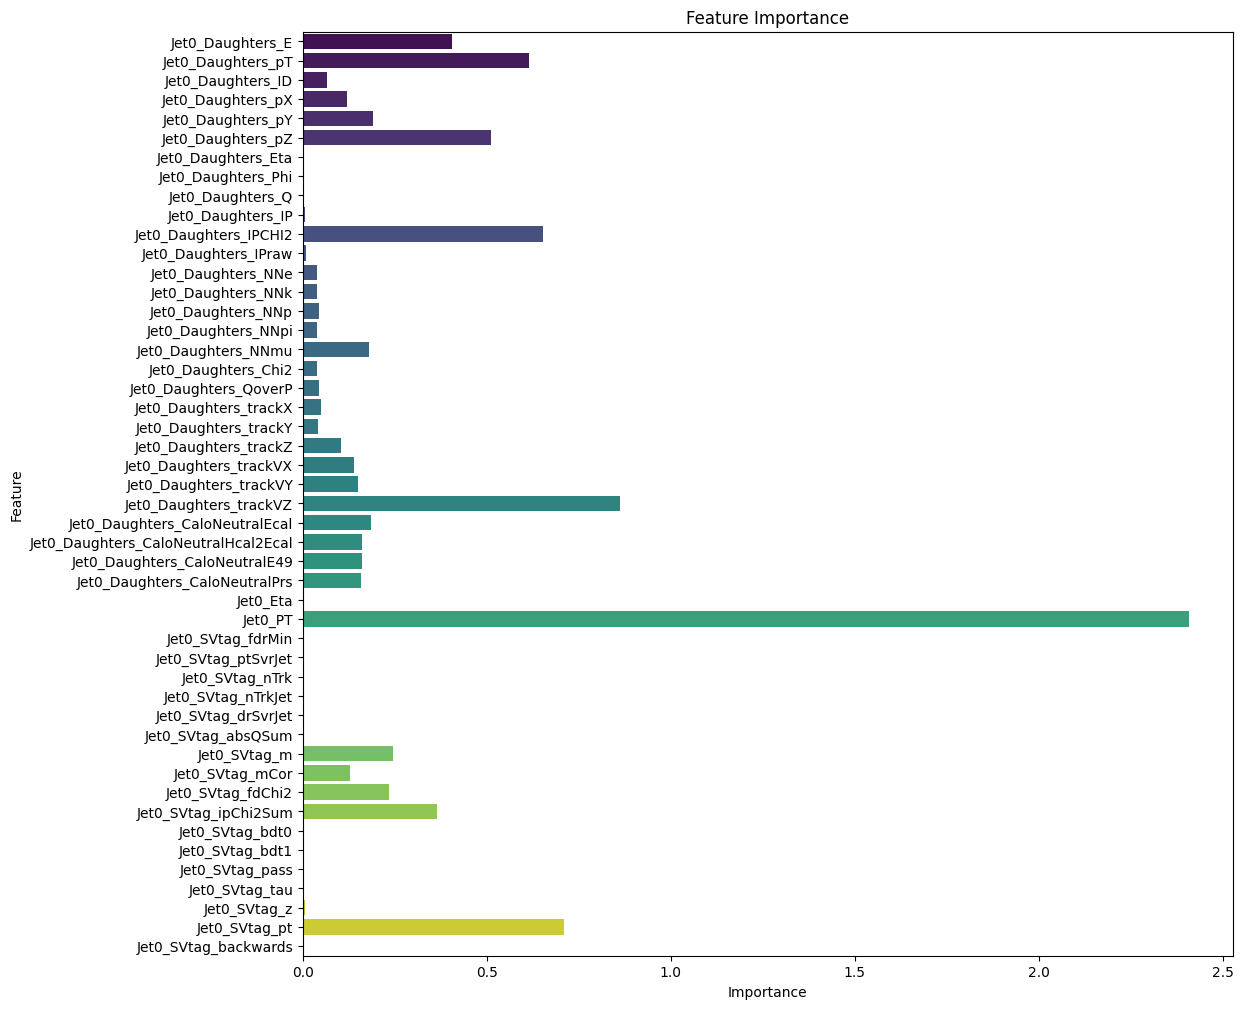

In [129]:
# Prepare model
model.eval()
data = next(iter(test_loader))
x, edge_index, batch = data.x, data.edge_index, data.batch

# Construct a graph
G = nx.Graph()
edges = list(zip(edge_index[0].numpy(), edge_index[1].numpy()))
G.add_edges_from(edges)

feature_importances = np.zeros(x.size(1)) #initialize with zeros for each feature

# Calculate importance for each feature
for feature_idx in range(x.size(1)):
    x_perturbed = x.clone()
    x_perturbed[:, feature_idx] = 0

    # Predict with original features
    with torch.no_grad():
        orig_pred = model(x, edge_index, batch)
        perturbed_pred = model(x_perturbed, edge_index, batch)

    # Compute importance - difference in predictions
    importance = torch.mean(torch.abs(orig_pred - perturbed_pred)).item()
    feature_importances[feature_idx] = importance

# Convert to DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importances})

# Print feature importances
print(importance_df)

# Plot feature importances
plt.figure(figsize=(12, 12))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', hue='Feature', dodge=False)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()